In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms as T

In [2]:
train_data_path = 'C:\\DATA\\Covid19-dataset\\train'
test_data_path = 'C:\\DATA\\Covid19-dataset\\test'

In [3]:
train_transforms = T.Compose([T.Resize((224, 224)), 
                              T.RandomHorizontalFlip(p = 0.5),
                              T.RandomPerspective(distortion_scale = 0.5, p = 0.5),
                              T.ToTensor(), 
                              T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
test_transforms = T.Compose([T.Resize((224, 224)), 
                             T.ToTensor(), 
                             T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

In [4]:
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = train_transforms)
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)

In [5]:
len(train_data), len(test_data)

(251, 66)

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = 8, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 8, shuffle = False)

In [18]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
class_names = ['Covid', 'Normal', 'Viral Pneumonia']

In [8]:
images, labels = next(iter(train_dataloader))

In [27]:
[class_names[i] for i in labels]

['Viral Pneumonia',
 'Normal',
 'Covid',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Covid',
 'Covid']

In [14]:
def show_input(image, title = ''):
    image = image.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.figure(figsize=(18,15))
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

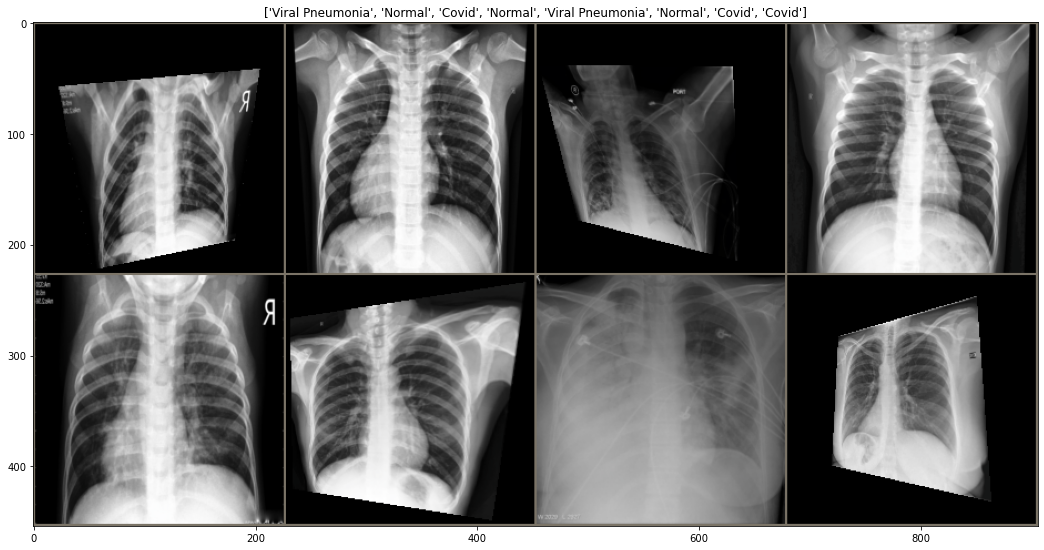

In [28]:
show_input(torchvision.utils.make_grid(images, nrow = 4), [class_names[i] for i in labels])

In [20]:
model = torchvision.models.resnet152(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\Анастасия/.cache\torch\hub\checkpoints\resnet152-b121ed2d.pth


In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
for param in model.parameters():
    param.requires_grad = False

In [23]:
model.fc = torch.nn.Linear(model.fc.in_features, 3)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = model.to(device)

In [26]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [31]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, n_epochs):
    
    train_loss = []
    val_loss = []
    val_acc = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_acc = []
        
        model.train()
        
        for image, label in tqdm(train_loader):
            optimizer.zero_grad()
            image = image.to(device)
            label = label.to(device)
            predictions = model(image)
            loss = loss_fn(predictions, label)
            loss.backward()
            optimizer.step()
            ep_train_loss.append(loss.item())
            
        model.eval()
        
        with torch.no_grad():
            for image, label in tqdm(val_loader):
                image = image.to(device)
                label = label.to(device)
                predictions = model(image)
                loss = loss_fn(predictions, label)
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_acc.append(np.mean( (label.cpu() == y_pred.cpu()).numpy() ))
                
        print(f'Epoch {epoch + 1} of {n_epochs}')
        
        scheduler.step()
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_acc.append(np.mean(ep_val_acc))
        
        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t validation loss: {val_loss[-1]:.6f}")
        print(f"\t validation accuracy: {val_acc[-1]:.3f}")
        
    return train_loss, val_loss, val_acc

In [28]:
def plot_train_process(train_loss, val_loss, val_acc):
    fig, axes = plt.subplots(1, 2, figsize = (15,5))
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label = 'train')
    axes[0].plot(val_loss, label = 'validation')
    axes[0].legend()
    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_acc)

In [32]:
train_loss, val_loss, val_acc = train_model(model, train_dataloader, test_dataloader, loss, optimizer, scheduler, 20)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 of 20
	 training loss: 0.799608
	 validation loss: 0.624162
	 validation accuracy: 0.722


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 of 20
	 training loss: 0.712549
	 validation loss: 0.604235
	 validation accuracy: 0.750


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 of 20
	 training loss: 0.587629
	 validation loss: 0.365922
	 validation accuracy: 0.903


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 of 20
	 training loss: 0.569293
	 validation loss: 0.366254
	 validation accuracy: 0.889


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 of 20
	 training loss: 0.666496
	 validation loss: 0.409624
	 validation accuracy: 0.806


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 of 20
	 training loss: 0.507231
	 validation loss: 0.324338
	 validation accuracy: 0.917


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 of 20
	 training loss: 0.449507
	 validation loss: 0.348424
	 validation accuracy: 0.889


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 of 20
	 training loss: 0.496188
	 validation loss: 0.336816
	 validation accuracy: 0.917


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 of 20
	 training loss: 0.459415
	 validation loss: 0.345951
	 validation accuracy: 0.903


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 of 20
	 training loss: 0.431365
	 validation loss: 0.340903
	 validation accuracy: 0.917


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 of 20
	 training loss: 0.398581
	 validation loss: 0.333067
	 validation accuracy: 0.917


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 of 20
	 training loss: 0.433051
	 validation loss: 0.323837
	 validation accuracy: 0.917


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 of 20
	 training loss: 0.427253
	 validation loss: 0.324636
	 validation accuracy: 0.917


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 of 20
	 training loss: 0.448406
	 validation loss: 0.337593
	 validation accuracy: 0.889


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 of 20
	 training loss: 0.413316
	 validation loss: 0.334945
	 validation accuracy: 0.903


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 of 20
	 training loss: 0.474563
	 validation loss: 0.328434
	 validation accuracy: 0.903


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 of 20
	 training loss: 0.440320
	 validation loss: 0.320181
	 validation accuracy: 0.931


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 of 20
	 training loss: 0.395231
	 validation loss: 0.294241
	 validation accuracy: 0.917


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 of 20
	 training loss: 0.411961
	 validation loss: 0.327979
	 validation accuracy: 0.917


100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

Epoch 20 of 20
	 training loss: 0.482567
	 validation loss: 0.330865
	 validation accuracy: 0.903


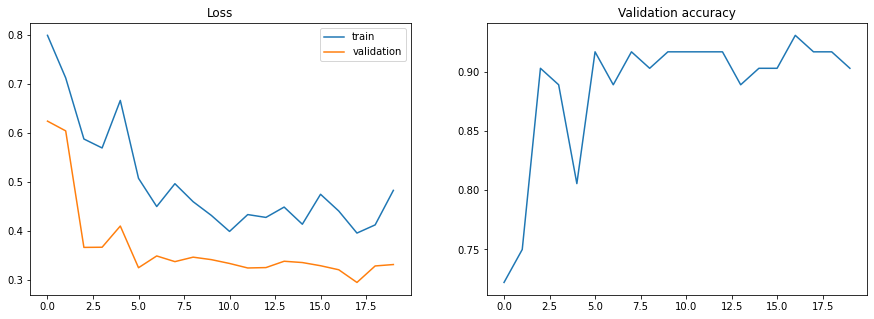

In [33]:
plot_train_process(train_loss, val_loss, val_acc)